# ANALYSIS

### Import Packages

In [406]:
# Import Packages
import pandas as pd # Matrix Operations
import numpy as np # Linear Algebra
import os # OS Functions

# GRAPHING
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.patches as mpatches
import seaborn as sns
import seaborn.objects as so
# %matplotlib inline

# MACHINE LEARNING
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, SpectralClustering, OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import manifold


# NATURAL LANGUAGE PROCCESSING (NLP)
import gensim
import gensim.downloader as api
from gensim.models import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# MISC
import distinctipy # Generate n colors
import re # Regex
import random # Random Operations
import string
from itertools import chain
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

from typing import *

class COLOR:
    """Class for displaying colored text in console outputs
    
    Use 'COLOR.<color>' in print statement before text.
    """
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    LIGHT_PURPLE = '\033[35m'
    LIGHT_CYAN = '\033[36m'
    LIGHT_BLUE = '\033[34m'
    LIGHT_GREEN = '\033[32m'
    LIGHT_YELLOW = '\033[33m'
    LIGHT_RED = '\033[31m'
    BOLD = '\033[1m'
    BOLD_OFF = '\033[21m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def make_table(values: pd.Series, dropna: bool = False, dec: int = 3) -> pd.DataFrame:
    """Output a frequency table for a set of values.

    Parameters:
    values (DataFrame Column): values 
    dropna (boolean)(default: False): Drop NAN values before frequency calculation.
    dec (int)(default: 3): Number of decimal places to round 'pct' column to.

    Returns:
    (pd.DataFrame): Frequency Table.
    """
    df = pd.value_counts(values, dropna=dropna).to_frame().reset_index()
    df['pct'] = round(df['count'] / sum(df['count']), dec)
    return(df)

def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """Clean SEM data from rows and columns that are un-needed for analysis.

    Parameters:
    data (DataFrame): Data to be cleaned.

    Returns:
    (DataFrame): Cleaned DataFrame.
    """
    # Filtering Data to ensure they accepted the survey and they are eligible
    data = data[(data['s_eligible'] == "1") & (data['s_intro'] == "1")]
    # Drop columns: 's_eligible', 's_intro' and 4 other columns (That are all NRB Related)
    data = data.drop(columns=['s_eligible', 's_intro', 's_nrb', 's_nrb_residence', 's_nrb_us', 's_nrb_overnight', 's_datayear'])
    data = data.replace({'#NULL!':np.nan, None:np.nan}) # Converting #NULL!'s/None's to "NaN" datatype
    data = data.apply(pd.to_numeric, errors='ignore') # Convering column to numeric if possible
    return(data)

def clean_text(text: str, tokenizer: any, stopwords: set) -> list:
    """Clean text sentances from characters and words that are not needed to be vectorized.

    Parameters:
    text (str): sentence string to be cleaned.
    tokenizer (function): Tokenizer function to be used.
    stopwords (set): Set of stopwords to use.

    Returns:
    list: list of token words for each sentence
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return(tokens)

def vectorize(list_of_docs: np.array, model: gensim.models.keyedvectors.KeyedVectors, api_model: bool = False) -> list:
    """Generate vectors for list of documents using Word Embedding.

    Parameters:
    list_of_docs (Array): array of tokenized words.
    model (Gensim Model): model to generate vectors.
    api_model (bool)(default: False): Boolean to declare if the model is from an api.

    Returns:
    list: list of vector features.
    """
    features = [] # List of Features
    for tokens in list_of_docs: # For each set of tokens in the list of docs
        zero_vector = np.zeros(model.vector_size) # Initialize vector
        vectors = [] # List of Vectors
        for token in tokens: # For each token in sentence
            if api_model: # If the model is an api model (different syntax required)
                if token in model: # Only add tokens that are known to the wv model to the vector list
                    try:
                        vectors.append(model[token])
                    except KeyError:
                        continue
            else: # Otherwise the model is trained by us (different syntax required)
                if token in model.wv: # Only add tokens that are known to the wv model to the vector list
                    try:
                        vectors.append(model.wv[token])
                    except KeyError:
                        continue
        if vectors: # If the List is not empty
            vectors = np.asarray(vectors) # Convert to Array
            avg_vec = vectors.mean(axis=0) # Calculate Mean
            features.append(avg_vec) # Add to Features
        else:
            features.append(zero_vector) # Otherwise add empty vector to Features
    return(features)

def set_all_seeds(seed: int = 42, echo: bool = True) -> None:
    """Function to set all seeds for reproducibility.

    Parameters:
    seed (int)(default: 42): Integer to set the seeds to.
    echo (bool)(default: True): Boolean to declare if function can output to console.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    if echo:
        print(COLOR.GREEN, "Seeds have been set to: ", COLOR.BOLD, seed, COLOR.END, sep='')

def get_text_cols(data: pd.DataFrame) -> list:
    """Get list of all string columns from SEM dataset

    Parameters:
    data (DataFrame): Dataframe to check columns

    Returns:
    list: list of all column headers that start with 'o' (i.e text column)
    """
    return([x for x in data if x.startswith('o')]) #Columns that start with 'o'

class NLP():
    """Class to hold information, data and function for Natural Language Proccessing(NLP) clusters.
    

    """
    def __init__(self, data: pd.Series, model: gensim.models.keyedvectors.KeyedVectors = None, echo: bool = True, reset_seeds: bool = True) -> Any:
        """ NLP class to hold cluster information/data

        Parameters:
        data (DataFrame Column): data to be analyzed.
        model (Gensim model): model to be used for NLP.
        echo (bool)(default: True): Boolean to declare if function can output to console.
        reset_seeds (bool)(default: True): Boolean to declare if set_all_seeds() function is called.

        Returns:
        object to hold information/data on the NLP cluster.

        Available Functions:

        dimension_reduce()
        
        clusterize()

        get_sil_values()

        get_cluster_labels()

        get_cluster()

        get_clusters()

        viz_clusters_mpl()

        viz_clusters()
        """
        self.data = data # Storing data into class
        # Booleans to keep track of what operations have been done for helper functions
        self.vectorized = False
        self.dim_reduced = False
        self.clustered = False

        if reset_seeds: # Reset seeds for reproducibility
            set_all_seeds(echo=echo)
            
        # Cleaning Data
        temp_frame = pd.DataFrame(np.array(data.copy()), columns=['variable']) # Convert column to array, drop NaN's
        temp_frame = temp_frame[~temp_frame['variable'].isnull()] # Remove null rows
        self.indexi = temp_frame.index # Keep Track of index for future analysis
        if echo:
            print(len(temp_frame), 'total samples') # Log samples
        
        # Generate stopwords, tokens and vectors for NLP model
        custom_stopwords = set(stopwords.words("english")) # Declare stop words
        temp_frame['tokens'] = temp_frame['variable'].map(lambda x: clean_text(x, word_tokenize, custom_stopwords)) # Remove stopwords/uneeded characters
        self.docs = temp_frame['variable'].values # English type values for sentances
        self.tokenized_docs = temp_frame['tokens'].values # Creating tokenized values from english words
        
        # Creating the Model
        if model == None: # Create own model
            self.model = Word2Vec(sentences=self.tokenized_docs, vector_size=100, workers=1, seed=seed) # Feeding the tokenized values into the model
            self.vectorized_docs = vectorize(self.tokenized_docs, model=self.model) # Creating vectors for each doc
        else: # Use API model
            self.model = model
            self.vectorized_docs = vectorize(self.tokenized_docs, model=self.model, api_model=True)
        if echo:
            print('Successfully Tokenized')
        self.vectorized = True

    def dimension_reduce(self, dim_redu_algorithm: str = 'pca', echo: bool = True, reset_seeds: bool = True) -> None:
        """Function to reduce n-dimensional vectors to 2-dimensions.

        Parameters:
        dim_redu_algorithm (str)(default: 'pca'): Algorithm to reduce dimensions (see list below).
        echo (bool)(default: True): Boolean to declare if function can output to console.
        reset_seeds (bool)(default: True): Boolean to declare if set_all_seeds() function is called.

        Returns:
        None

        Available dimension reduction algorithms:

        'pca': Principal Component Analysis

        'isomap': Non-Linear - Isometric Mapping

        'tsne': T-distributed Stochastic Neighbor Embedding

        'mds': Multidimensional Scaling

        'lle': Locally Linear Embedding

        'spectral_emb': Spectral Embedding
        """
        if not self.vectorized: # Ensure data has been vectorized before reduction
            print(COLOR.RED, 'ERROR: No tokens found.', COLOR.END, sep='')
            return
        if reset_seeds: # Reset Seeds
            set_all_seeds(echo=echo)
        self.dim_redu_algorithm = dim_redu_algorithm # Setting the algorithm
        # Dimensionality Reducution to reduce to 2-dimensions
        if self.dim_redu_algorithm == 'pca': # Principal Component Analysis (PCA)
            self.pca = PCA(n_components=2).fit(self.vectorized_docs)
            self.datapoints = self.pca.transform(self.vectorized_docs)
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'isomap': # Non-Linear - Isometric Mapping (ISOMAP)
            self.iso = manifold.Isomap(n_neighbors=3, n_components=2).fit(self.vectorized_docs)
            self.datapoints = self.iso.transform(self.vectorized_docs)
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'tsne': # T-distributed Stochastic Neighbor Embedding (TSNE)
            self.tsn = manifold.TSNE(n_components=2, perplexity=50)
            self.datapoints = self.tsn.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'mds': # Multidimensional Scaling (MDS)
            self.mds = manifold.MDS(n_components=2, max_iter=10, eps=1)
            self.datapoints = self.mds.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'lle': # Locally Linear Embedding
            self.lle = manifold.LocallyLinearEmbedding(n_neighbors=5, n_components=2)
            self.datapoints = self.lle.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'spectral_emb': # Spectral Embedding
            self.lle = manifold.SpectralEmbedding(n_components=2)
            self.datapoints = self.lle.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        else:
            print(COLOR.RED, COLOR.BOLD, 'ERROR: ', self.dim_redu_algorithm, 'is not an available algorithm', COLOR.END)
            return
        self.datapoints['sentance'] = self.docs # Add the english sentances to the dataframe
        self.datapoints['orig_index'] = self.indexi # Add the original indexi to the dataframe for future analysis
        self.X = self.datapoints[['component1', 'component2']].to_numpy() # Convert X/Y components to self.X
        self.dim_reduced = True
        if echo:
            print(COLOR.DARKCYAN, 'Reduced dimensions to 2 using ', COLOR.BLUE, COLOR.BOLD, self.dim_redu_algorithm.upper(), COLOR.END, sep='')
    
    def clusterize(self, cluster_algorithm: str = 'kmeans', num_clusters: int = 15, echo: bool = True, reset_seeds: bool = True) -> None:
        """Apply Cluster Algorithms to group data.

        Parameters:
        cluster_algorithm (str)(default: 'kmeans'): Cluster Algorithm to use (see list below).
        num_clusters (int)(default: 15): Number of clusters to generate (does not apply to DBSCAN and OPTICS)
        echo (bool)(default: True): Boolean to declare if function can output to console.
        reset_seeds (bool)(default: True): Boolean to declare if set_all_seeds() function is called.

        Returns:
        None

        Available Cluster Algorithms to use:

        'kmeans': K-Means

        'kmeans_mb': MiniBatchK-Means

        'dbscan': Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

        'spectral_clustering': Spectral Clustering

        'optics': Ordering Points To Identify the Clustering Structure (OPTICS)

        """
        if not self.dim_reduced: # Ensure data has been reduced to 2-dimensions
            print(COLOR.RED, 'ERROR: Dimensions have not been reduced.', COLOR.END, sep='')
            return
        if reset_seeds: # Reset Seeds
            set_all_seeds(echo=echo)
        self.num_clusters = num_clusters # Setting number of clusters
        self.cluster_algorithm = cluster_algorithm # Setting cluster algorithm
        # KMEANS
        if (self.cluster_algorithm == 'kmeans'):
            self.km = KMeans(n_clusters=self.num_clusters).fit(self.X)
            self.ca = self.km
            self.datapoints['cluster'] = self.km.labels_
        # MINIBATCH_KMEANS
        elif (self.cluster_algorithm == 'kmeans_mb'):
            self.km = MiniBatchKMeans(n_clusters=self.num_clusters, batch_size=500, n_init='auto').fit(self.X)
            self.ca = self.km
            self.datapoints['cluster'] = self.km.labels_
        # DBSCAN
        elif (self.cluster_algorithm == 'dbscan'):
            self.db = DBSCAN(eps=0.01, min_samples=20).fit(self.X)
            self.ca = self.db
            self.num_clusters = len(set(self.db.labels_)) - (1 if -1 in self.db.labels_ else 0) # Number of clusters (not including -1, i.e samples that do not fit in a cluster)
            self.datapoints['cluster'] = self.db.labels_
        # SPECTRAL CLUSTERING
        elif (self.cluster_algorithm == 'spectral_clustering'):
            self.sc = SpectralClustering(n_clusters=self.num_clusters).fit(self.X)
            self.ca = self.sc
            self.datapoints['cluster'] = self.sc.labels_
        # OPTICS
        elif (self.cluster_algorithm == 'optics'):
            self.op = OPTICS(min_samples=5).fit(self.X)
            self.ca = self.op
            self.datapoints['cluster'] = self.op.labels_
        else:
            print(COLOR.RED, COLOR.BOLD, 'ERROR: ', self.cluster_algorithm, 'is not an available algorithm', COLOR.END)
            return
        self.clustered = True
        if echo:
            print(COLOR.DARKCYAN, 'Clustered using ', COLOR.BLUE, COLOR.BOLD, self.cluster_algorithm.upper(), COLOR.END, sep='')
            print(COLOR.YELLOW, "For n_clusters = ", str(self.num_clusters), COLOR.END, sep='')
            print(COLOR.YELLOW, COLOR.BOLD, f"Silhouette coefficient: {silhouette_score(self.X, self.ca.labels_):0.2f}", COLOR.END, sep='')
            try:
                print(COLOR.YELLOW, COLOR.BOLD, f"Inertia: {self.ca.inertia_:0.3f}", COLOR.END, sep='')
            except:
                pass
    def get_sil_values(self) -> None:
        """Print Silhouette Values for each cluster to console.

        Parameters:
        None

        Returns:
        None
        """
        if not self.clustered: # Ensure data has been clustered first
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        sample_silhouette_values = silhouette_samples(self.X, self.ca.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(self.num_clusters):
            cluster_silhouette_values = sample_silhouette_values[self.ca.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )

    def get_cluster_labels(self) -> list:
        """Get Cluster Labels
        
        Parameters:
        None

        Returns:
        list: List of clusters.
        """
        if not self.clustered: # Ensure data has been clustered first
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        return(list(np.unique(self.datapoints['cluster'])))

    def get_cluster(self, cluster: int = None) -> pd.DataFrame:
        """Get Cluster Information (components 1 and 2, sentence, orig_index, cluster, colorCode, alpha)
        
        Parameters:
        cluster (int): Number of cluster to get information for.

        Returns:
        DataFrame: Dataframe with cluster information
        """
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        if cluster is None:
            print(COLOR.RED, 'ERROR: Please enter a cluster.', COLOR.END, sep='')
            return
        return(self.datapoints[self.datapoints['cluster'] == cluster])

    def get_clusters(self, cluster_filter: list = None) -> pd.DataFrame:
        """Get Dataframe of cluster sentences split by cluster

        Parameters:
        cluster_filter (list)(default: all clusters): list of clusters to retrieve

        Returns:
        DataFrame: Dataframe of clusters(cols) with sentences for each cluster(rows)
        """
        if not self.clustered: # Ensure data has been clustered first
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        # Filter by Cluster
        if cluster_filter is None:
            cluster_filter = self.get_cluster_labels()

        df = pd.DataFrame()
        for clust in self.get_cluster_labels():
            if clust in cluster_filter:
                df = pd.concat([df, pd.DataFrame(self.get_cluster(clust)['sentance'].to_numpy(), columns=['cluster_' + str(clust)])], axis=1)
        return(df)

    def viz_clusters_mpl(self, cluster_filter: list = None, figsize: tuple = (10, 10), num_annotations: int = 100, max_char_length: int = 20, hide_labels: bool = False, hide_legend: bool = False, echo = True, reset_seeds: bool = True) -> None:
        """Visualize Clusters using matplotlib
        Parameters:
        cluster_filter (list)(default: all clusters): List of clusters to display.
        figsize (tuple)(default: (10, 10)): X and Y size for plot.
        num_annotations (int)(default: 100): Number of random text sentence annotations to display.
        max_char_length (int)(default: 20): Limit of characters for a random sentence to be annotated.
        hide_labels: (bool)(default: False): Boolean to declare whether the annotations are hidden or not.
        hide_legend: (bool)(default: False): Boolean to declare whether the legend is hidden or not.
        echo (bool)(default: True): Boolean to declare if function can output to console.
        reset_seeds (bool)(default: True): Boolean to declare if set_all_seeds() function is called.

        Returns:
        None (Except for Plot Display)
        """
        # Declaring Figsize
        if not self.clustered: # Ensure data has been clustered first
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        if reset_seeds: # Reset Seeds
            set_all_seeds(echo=echo)
        plt.figure(figsize=figsize, dpi=100)

        # Declaring Colors based on Clusters
        color_list = distinctipy.get_colors(self.num_clusters)
        # self.datapoints['colorCode'] = [color_list[x] for x in self.datapoints['cluster']]
        self.datapoints['colorCode'] = [(0,0,0) if x == -1 else color_list[x] for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes unused points the Black cluster)
        self.datapoints['alpha'] = [0.05 if x == -1 else 0.3 for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes Black points more transparent)
        chart_data = self.datapoints.copy()
        
        # Filter by Cluster
        if cluster_filter is not None:
            chart_data = chart_data[chart_data['cluster'].isin(cluster_filter)]
        else:
            cluster_filter = self.get_cluster_labels()

        # Plot datapoints with associated colors/alphas
        plt.scatter(chart_data['component1'], chart_data['component2'], s=50, color=chart_data['colorCode'], alpha=chart_data['alpha'], edgecolors='none')
        # Setting X/Y Labels
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")

        # Display Legend
        if ~hide_legend:
            patchList = []
            for i, color in enumerate(color_list):
                if i in cluster_filter:
                    data_key = mpatches.Patch(color=color, label='Cluster ' + str(i))
                    patchList.append(data_key)
            plt.legend(handles=patchList, title='Cluster')
        
        # Display random labels
        if ~hide_labels:
            num_annotated = 0
            while (True):
                # Ensures we only annotate x amount of labels
                if (num_annotated == num_annotations):
                    break
                # Grab Random Point
                sent_num = np.random.randint(0, len(chart_data))
                # Ensuring Sentance is less than specified length for readability
                if (len(chart_data.iloc[sent_num]['sentance']) <= max_char_length):
                    plt.annotate(chart_data.iloc[sent_num]['sentance'], (chart_data.iloc[sent_num]['component1'], chart_data.iloc[sent_num]['component2']), size = 7, weight='bold')
                    num_annotated += 1
        # Set Plot Title and Display
        plt.title('dim_redu_alg: ' + self.dim_redu_algorithm.upper() + ' clust_alg: ' + self.cluster_algorithm.upper() + ' ' + str(self.num_clusters) + ' clusters')
        plt.show()

    def viz_clusters(self, cluster_filter: list = None, figsize: tuple = (10, 10), num_annotations: int = 100, max_char_length: int = 20, hide_labels: bool = False, hide_legend: bool = False, echo = True, reset_seeds: bool = True, jitter: bool = True) -> None:
        """Visualize Clusters using seaborne
        Parameters:
        cluster_filter (list)(default: all clusters): List of clusters to display.
        figsize (tuple)(default: (10, 10)): X and Y size for plot.
        num_annotations (int)(default: 100): Number of random text sentence annotations to display.
        max_char_length (int)(default: 20): Limit of characters for a random sentence to be annotated.
        hide_labels: (bool)(default: False): Boolean to declare whether the annotations are hidden or not.
        hide_legend: (bool)(default: False): Boolean to declare whether the legend is hidden or not.
        echo (bool)(default: True): Boolean to declare if function can output to console.
        reset_seeds (bool)(default: True): Boolean to declare if set_all_seeds() function is called.
        jitter (bool)(default: True): Boolean to declare if the points are jittered for better readability.

        Returns:
        None (Except for Plot Display)
        """
        if not self.clustered: # Ensure data has been clustered first
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        if reset_seeds: # Reset Seeds
            set_all_seeds(echo=echo)
        plt.figure(figsize=figsize, dpi=100)

        # Declaring Colors based on Clusters
        color_list = distinctipy.get_colors(self.num_clusters)
        # self.datapoints['colorCode'] = [color_list[x] for x in self.datapoints['cluster']]
        self.datapoints['colorCode'] = [(0,0,0) if x == -1 else color_list[x] for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes unused points the Black cluster)
        self.datapoints['alpha'] = [0.05 if x == -1 else 0.3 for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes Black points more transparent)
        chart_data = self.datapoints.copy()
        if jitter:
            chart_data.component1 = chart_data.component1 + np.random.normal(0.01 ,0.01,chart_data.component1.shape)
            chart_data.component2 = chart_data.component2 + np.random.normal(0.01 ,0.01,chart_data.component1.shape)
        # Filter by Cluster
        if cluster_filter is not None:
            chart_data = chart_data[chart_data['cluster'].isin(cluster_filter)]
        else:
            cluster_filter = self.get_cluster_labels()
        
        f, ax = plt.subplots(figsize=(12, 12))
        sns.set_style('white')
        sns.scatterplot(data=chart_data, x=chart_data.component1, y=chart_data.component2, hue='cluster', palette=color_list, alpha=self.datapoints['alpha'], edgecolor = None)
        # sns.scatterplot(data=chart_data, x=jitter(chart_data.component1, 0.01), y=jitter(chart_data.component2, 0.01), hue='cluster', palette=color_list, alpha=self.datapoints['alpha'], edgecolor = None)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.legend(title='Cluster')
        plt.title('dim_redu_alg: ' + self.dim_redu_algorithm.upper() + ' clust_alg: ' + self.cluster_algorithm.upper() + ' ' + str(self.num_clusters) + ' clusters')
        # Display rabdom labels
        if ~hide_labels:
            num_annotated = 0
            while (True):
                # Ensures we only annotate x amount of labels
                if (num_annotated == num_annotations):
                    break
                # Grab Random Point
                sent_num = np.random.randint(0, len(chart_data))
                # Ensuring Sentance is less than specified length for readability
                if (len(chart_data.iloc[sent_num]['sentance']) <= max_char_length):
                    plt.text(chart_data.iloc[sent_num]['component1'], chart_data.iloc[sent_num]['component2'], chart_data.iloc[sent_num]['sentance'], size = 7, weight='bold')
                    num_annotated += 1
        plt.show()

### Import Data

In [335]:
# Import Data
data = pd.read_parquet(r"C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data\nationalData.parquet")
print('Before Filter: ', data.shape)
# data.head()

data_clean = clean_data(data.copy())
print('Post Filter: ', data_clean.shape)
data_clean.head()

Before Filter:  (28082, 346)
<class 'pandas.core.frame.DataFrame'>
Post Filter:  (19977, 339)


,n_IQualtricsID,s_QualtricsLang,o_eligible,s_residence,n_loczip,s_us_int,s_country_int,n_zip_int,s_primary,s_purpose,...,m_act_climb,o_act_climb,m_accom_lodge,n_nightslodge,c_nightslodge,s_npssite,s_sitetype,s_sitesize,s_region,weight_peak
0,R_5ZzD8xdz24Bx17j,EN,NaN,3.0,NaN,1.0,NaN,76107.0,1.0,NaN,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
1,R_fvd9VW1Y8umSWOW,EN,NaN,3.0,NaN,1.0,NaN,78130.0,1.0,NaN,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
2,R_2Nnte2VxZyBU1Er,EN,NaN,3.0,NaN,1.0,NaN,76643.0,1.0,NaN,...,NaN,NaN,0.0,NaN,NaN,1,1,1,5,0.03
3,R_efmlxcfYDsQNzoJ,EN,NaN,3.0,NaN,1.0,NaN,99349.0,2.0,3.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
4,R_6pb7kqH2oedoEzZ,EN,NaN,3.0,NaN,1.0,NaN,41035.0,2.0,3.0,...,0.0,NaN,NaN,NaN,NaN,1,1,1,5,0.03


In [152]:
# MODEL TO USE FOR NLP
modelGN300 = api.load('word2vec-google-news-300')
# api.info()

In [376]:
type(word_tokenize)

function

Seeds have been set to: 42
3293 total samples
Successfully Tokenized
Seeds have been set to: 42
Reduced dimensions to 2 using PCA
Seeds have been set to: 42
Clustered using KMEANS
For n_clusters = 15
Silhouette coefficient: 0.40
Inertia: 64.210
<class 'list'>
Seeds have been set to: 42


<Figure size 1000x1000 with 0 Axes>

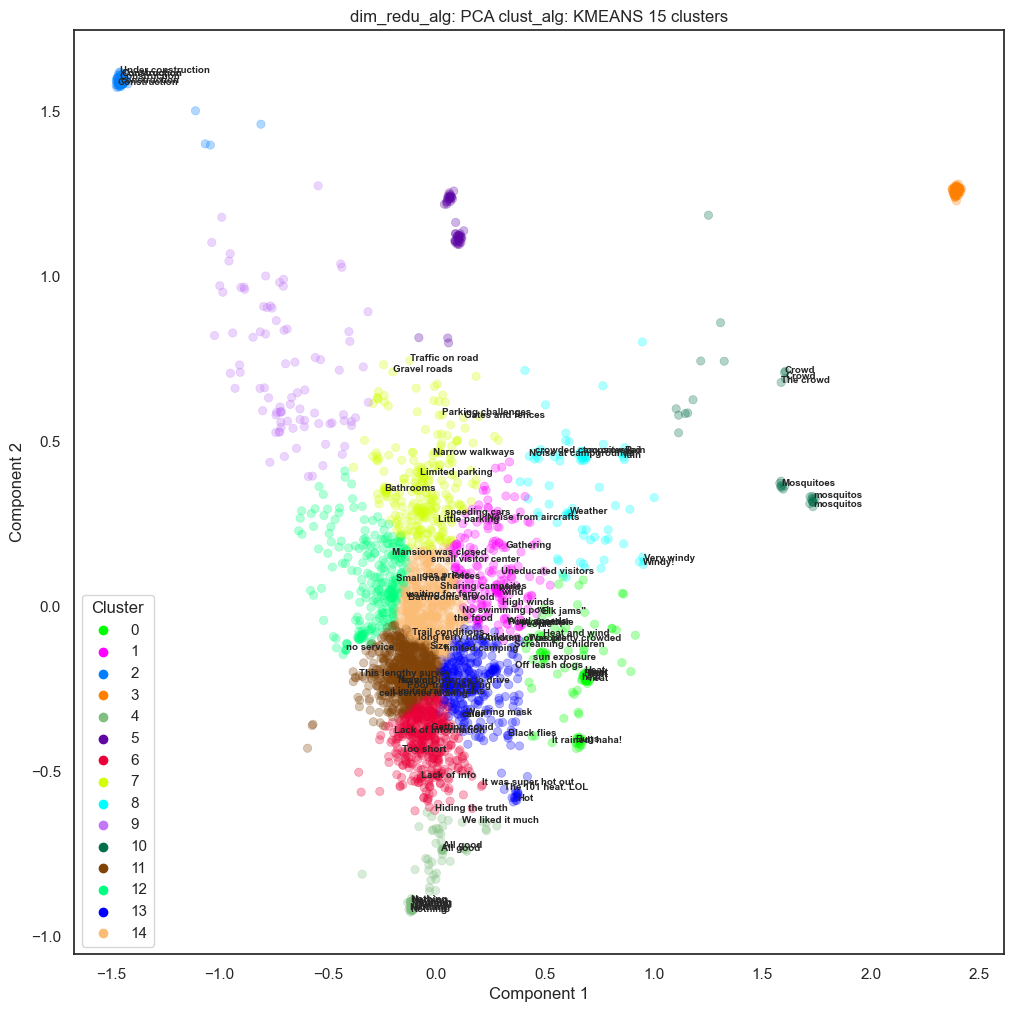

In [404]:
test = NLP(data_clean['o_least1'].iloc[:], model=modelGN300)
test.dimension_reduce('pca')
test.clusterize('kmeans', num_clusters=15)
test.viz_clusters()

In [153]:
get_text_cols(data_clean)

['o_eligible',
 'o_comm',
 'o_commstay1',
 'o_commstay2',
 'o_entermode',
 'o_enterwater',
 'o_zipflag',
 'o_zipflag2',
 'o_info_osite',
 'o_info_other',
 'o_infoneed',
 'o_mode_other',
 'o_mode_otherwater',
 'o_type',
 'o_fee',
 'o_parks',
 'o_act_nonmotor',
 'o_act_motor',
 'o_act_waterplay',
 'o_act_other1',
 'o_act_other2',
 'o_act_other3',
 'o_motiv_other',
 'o_prog_other',
 'o_history',
 'o_subjects',
 'o_tech_other',
 'o_itech_other',
 'o_disability',
 'o_like1',
 'o_like2',
 'o_like3',
 'o_least1',
 'o_least2',
 'o_least3',
 'o_expect1',
 'o_expect2',
 'o_qual_other',
 'o_sig',
 'o_gender',
 'o_race',
 'o_langother',
 'o_addl',
 'o_act_climb']

## VAR1: o_least1

In [156]:
var1_model1 = NLP(data_clean['o_least1'].iloc[:], model=modelGN300)
var1_model1.dimension_reduce('tsne')

Seeds have been set to: 42
3293 total samples
Successfully Tokenized
Seeds have been set to: 42
Reduced dimensions to 2 using TSNE


Seeds have been set to: 42
Clustered using KMEANS
For n_clusters = 15
Silhouette coefficient: 0.39
Inertia: 477310.125
Seeds have been set to: 42


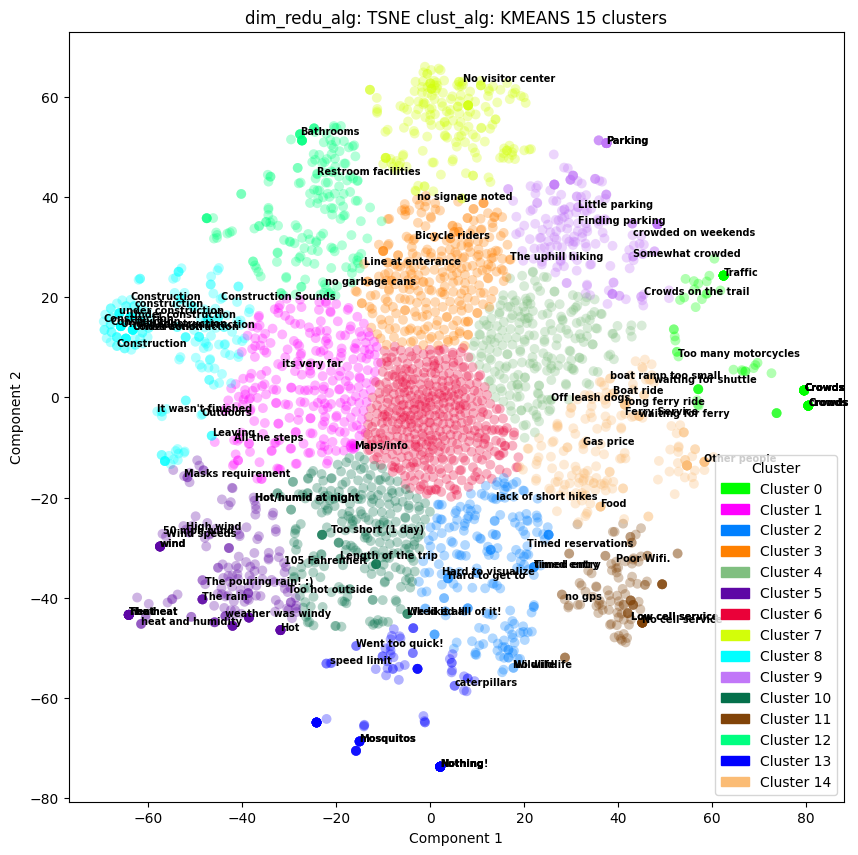

In [157]:
var1_model1.clusterize(cluster_algorithm='kmeans', num_clusters=15)
var1_model1.viz_clusters()

In [162]:
var1_model1_wifi_data = var1_model1.get_cluster(11)
var1_model1_wifi_data.head()

,component1,component2,sentance,orig_index,cluster,colorCode,alpha
42,41.114792,-41.379433,Lack of cell phone service,126,11,"(0.5052549606196312, 0.2612685349876185, 0.032...",0.3
43,29.545599,-31.180719,Remote,127,11,"(0.5052549606196312, 0.2612685349876185, 0.032...",0.3
120,36.701256,-42.427536,"wish we had cell service, but wasn't necessary",347,11,"(0.5052549606196312, 0.2612685349876185, 0.032...",0.3
169,41.021530,-25.207390,our lack of time,479,11,"(0.5052549606196312, 0.2612685349876185, 0.032...",0.3
180,42.631645,-40.530880,lack of cell service,507,11,"(0.5052549606196312, 0.2612685349876185, 0.032...",0.3


In [163]:
df = data_clean.filter(var1_model1_wifi_data.orig_index, axis=0)
df.head()

,n_IQualtricsID,s_QualtricsLang,o_eligible,s_residence,n_loczip,s_us_int,s_country_int,n_zip_int,s_primary,s_purpose,...,m_act_climb,o_act_climb,m_accom_lodge,n_nightslodge,c_nightslodge,s_npssite,s_sitetype,s_sitesize,s_region,weight_peak
126,R_foQzXcmlm3kiCfd,EN,NaN,3.0,NaN,1.0,NaN,75028.0,2.0,1.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
127,R_cgVxTqjDOjdEqdQ,EN,NaN,3.0,NaN,1.0,NaN,85050.0,2.0,2.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
347,R_28yknakKtQAG7e3,EN,NaN,3.0,NaN,1.0,NaN,53227.0,2.0,2.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
479,R_nJy29uOJ6riGu13,EN,NaN,3.0,NaN,1.0,NaN,98271.0,2.0,2.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
507,R_9lKEuEXq2cDGFub,EN,NaN,1.0,79901.0,1.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,1,1,1,5,0.03


In [164]:
df.columns[1:10]

Index(['s_QualtricsLang', 'o_eligible', 's_residence', 'n_loczip', 's_us_int',
       's_country_int', 'n_zip_int', 's_primary', 's_purpose'],
      dtype='object')

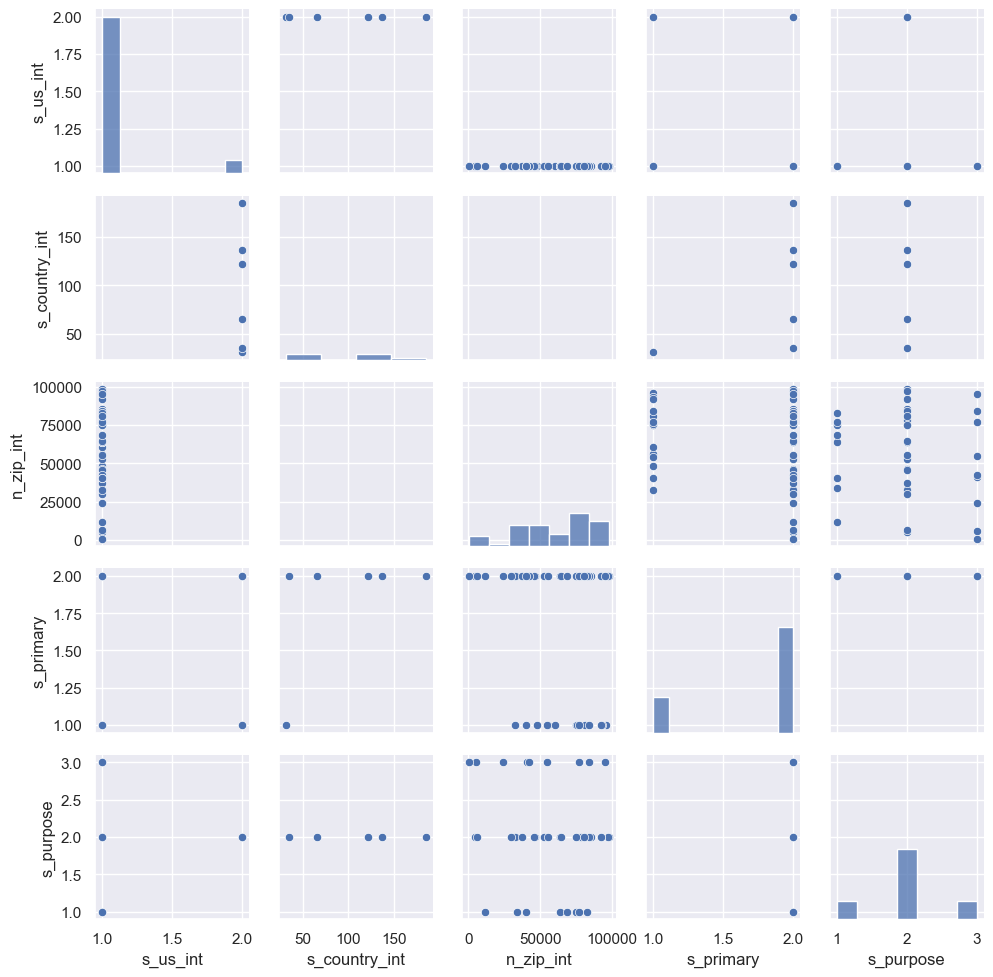

In [176]:
g = sns.PairGrid(df[df.columns[5:10]], height=2)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)